In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings


In [2]:
data = yf.download(tickers='^NDX', start = '2024-09-30',end = '2025-06-02')
data.columns = [f"{col[0]}" for col in data.columns]
data['RSI']=ta.rsi(data.Close, length=15)
data['EMAF']=ta.ema(data.Close, length=20)
data['EMAM']=ta.ema(data.Close, length=100)
data['EMAS']=ta.ema(data.Close, length=150)
indicator_cols = ['RSI', 'EMAF', 'EMAM', 'EMAS']
data[indicator_cols] = data[indicator_cols].fillna(method='bfill')
data['Adj Close'] = data[('Close')]
data['Target'] = data['Adj Close']-data.Open
data['Target'] = data['Target'].shift(-1)

data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]

data['TargetNextClose'] = data['Adj Close'].shift(-1)
data.dropna(inplace=True)
data.reset_index(inplace = True)
# Merge sentiment
# Load sentiment data
sentiment_df = pd.read_csv("../data/cleaned_scores.csv", parse_dates=["date"])

# Rename to match data DataFrame
sentiment_df.rename(columns={'date': 'Date'}, inplace=True)

# Merge on Date 
data = pd.merge(data, sentiment_df, how='left', on='Date')

# Fill missing sentiment values (e.g., weekends/holidays)
data[['avg_sentiment', 'avg_score', 'article_count']] = data[['avg_sentiment', 'avg_score', 'article_count']].fillna(method='ffill')



C:\Users\PC\AppData\Local\Temp\ipykernel_6364\445066659.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers='^NDX', start = '2024-09-30',end = '2025-06-02')
[*********************100%***********************]  1 of 1 completed
C:\Users\PC\AppData\Local\Temp\ipykernel_6364\445066659.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[indicator_cols] = data[indicator_cols].fillna(method='bfill')
C:\Users\PC\AppData\Local\Temp\ipykernel_6364\445066659.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]
C:\Users\PC\AppData\Local\Temp\ipykernel_6364\445066659.py:29: FutureW

In [3]:
data

,Date,Close,High,Low,Open,Volume,RSI,EMAF,EMAM,EMAS,Adj Close,Target,TargetClass,TargetNextClose,avg_sentiment,avg_score,article_count
0,2024-09-30,20060.689453,20072.429688,19852.849609,19959.259766,5846150000,0.000000,20142.361035,21028.616406,20494.101862,20060.689453,-272.759766,0,19773.300781,NaN,NaN,NaN
1,2024-10-01,19773.300781,20056.199219,19622.289062,20046.060547,5879980000,0.000000,20142.361035,21028.616406,20494.101862,19773.300781,76.640625,1,19802.589844,NaN,NaN,NaN
2,2024-10-02,19802.589844,19876.699219,19630.910156,19725.949219,5489040000,0.674845,20142.361035,21028.616406,20494.101862,19802.589844,81.009766,1,19793.339844,NaN,NaN,NaN
3,2024-10-03,19793.339844,19902.699219,19688.220703,19712.330078,5208990000,0.673314,20142.361035,21028.616406,20494.101862,19793.339844,9.859375,1,20035.019531,NaN,NaN,NaN
4,2024-10-04,20035.019531,20045.689453,19829.490234,20025.160156,5136070000,6.578794,20142.361035,21028.616406,20494.101862,20035.019531,-153.919922,0,19800.740234,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,2025-05-22,21112.470703,21263.179688,21046.220703,21097.460938,8289710000,62.902790,20527.453279,20159.611210,20561.294379,21112.470703,109.291016,1,20915.660156,0.013605,0.946303,294.0
162,2025-05-23,20915.660156,21025.580078,20777.970703,20806.369141,8730370000,59.460242,20564.425363,20174.582477,20565.987966,20915.660156,213.541016,1,21414.990234,0.086207,0.951137,290.0
163,2025-05-27,21414.990234,21429.320312,21145.130859,21201.449219,8927760000,64.689940,20645.431541,20199.145006,20577.233029,21414.990234,-133.519531,0,21318.169922,0.071918,0.939232,292.0
164,2025-05-28,21318.169922,21508.080078,21296.509766,21451.689453,8087530000,63.008799,20709.501863,20221.303916,20587.046763,21318.169922,-247.589844,0,21363.949219,-0.017123,0.946628,292.0


In [4]:
data = data[data['Date'] > pd.to_datetime('2024-12-31')].reset_index(drop=True)

In [5]:
data

,Date,Close,High,Low,Open,Volume,RSI,EMAF,EMAM,EMAS,Adj Close,Target,TargetClass,TargetNextClose,avg_sentiment,avg_score,article_count
0,2025-01-02,20975.619141,21236.589844,20800.500000,21120.050781,8737550000,44.444206,21333.410460,21028.616406,20494.101862,20975.619141,229.371094,1,21326.160156,0.010101,0.946864,297.0
1,2025-01-03,21326.160156,21359.630859,21075.890625,21096.789062,8214050000,50.377222,21332.719955,21028.616406,20494.101862,21326.160156,8.320312,1,21559.500000,-0.010169,0.937992,295.0
2,2025-01-06,21559.500000,21703.490234,21462.519531,21551.179688,9586840000,53.874768,21354.318054,21028.616406,20494.101862,21559.500000,-446.851562,0,21173.039062,-0.006969,0.953787,287.0
3,2025-01-07,21173.039062,21621.250000,21101.089844,21619.890625,13371130000,47.909262,21337.053388,21028.616406,20494.101862,21173.039062,24.210938,1,21180.970703,0.075601,0.949138,291.0
4,2025-01-08,21180.970703,21242.609375,20992.080078,21156.759766,8851720000,48.035229,21322.188371,21028.616406,20494.101862,21180.970703,-164.708984,0,20847.580078,0.000000,0.947489,291.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,2025-05-22,21112.470703,21263.179688,21046.220703,21097.460938,8289710000,62.902790,20527.453279,20159.611210,20561.294379,21112.470703,109.291016,1,20915.660156,0.013605,0.946303,294.0
97,2025-05-23,20915.660156,21025.580078,20777.970703,20806.369141,8730370000,59.460242,20564.425363,20174.582477,20565.987966,20915.660156,213.541016,1,21414.990234,0.086207,0.951137,290.0
98,2025-05-27,21414.990234,21429.320312,21145.130859,21201.449219,8927760000,64.689940,20645.431541,20199.145006,20577.233029,21414.990234,-133.519531,0,21318.169922,0.071918,0.939232,292.0
99,2025-05-28,21318.169922,21508.080078,21296.509766,21451.689453,8087530000,63.008799,20709.501863,20221.303916,20587.046763,21318.169922,-247.589844,0,21363.949219,-0.017123,0.946628,292.0


In [6]:
print(data['TargetClass'].value_counts())

TargetClass
1    57
0    44
Name: count, dtype: int64


In [7]:
feature_columns = ['High', 'Low', 'Open', 'Volume', 'RSI', 'EMAF', 'EMAM', 'EMAS', 'avg_sentiment']
backcandles = 15
X, y = [], data['TargetClass'].values[backcandles:]
for j in range(len(feature_columns)):
    X.append([data[feature_columns].iloc[i-backcandles:i, j].values for i in range(backcandles, len(data))])
X = np.moveaxis(X, [0], [2])
print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (86, 15, 9), y shape: (86,)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X.shape[2])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X.shape[2])).reshape(X_test.shape)
X_train_flat = X_train_scaled.reshape(X_train.shape[0], -1)
X_test_flat = X_test_scaled.reshape(X_test.shape[0], -1)



--- Training model 1 with config: {'lstm1': 100, 'lstm2': 50, 'dense1': 64, 'dense2': 32, 'drop1': 0.3, 'drop2': 0.3, 'drop3': 0.2, 'epochs': 20, 'batch_size': 32} ---



1/1 [==============================] - 1s 649ms/step
Best threshold: 0.37, F1 score: 0.7407

--- Training model 2 with config: {'lstm1': 128, 'lstm2': 64, 'dense1': 128, 'dense2': 64, 'drop1': 0.4, 'drop2': 0.3, 'drop3': 0.3, 'epochs': 30, 'batch_size': 64} ---


c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 505ms/step
Best threshold: 0.31, F1 score: 0.7500

=== Best Configuration ===
{'lstm1': 128, 'lstm2': 64, 'dense1': 128, 'dense2': 64, 'drop1': 0.4, 'drop2': 0.3, 'drop3': 0.3, 'epochs': 30, 'batch_size': 64}
Best F1 Score: 0.7500

--- Classification Report for Best Model ---
              precision    recall  f1-score   support

           0       0.75      0.38      0.50         8
           1       0.64      0.90      0.75        10

    accuracy                           0.67        18
   macro avg       0.70      0.64      0.62        18
weighted avg       0.69      0.67      0.64        18



c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


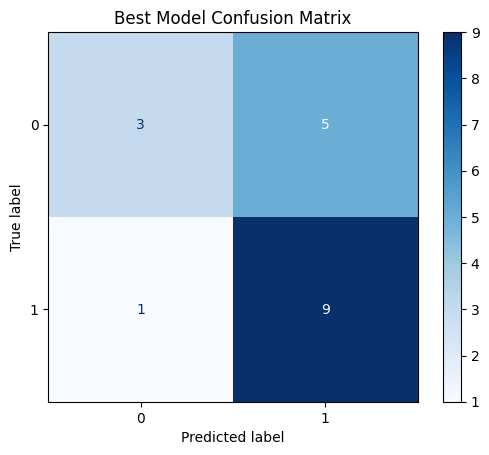

1/1 [==============================] - 0s 13ms/step


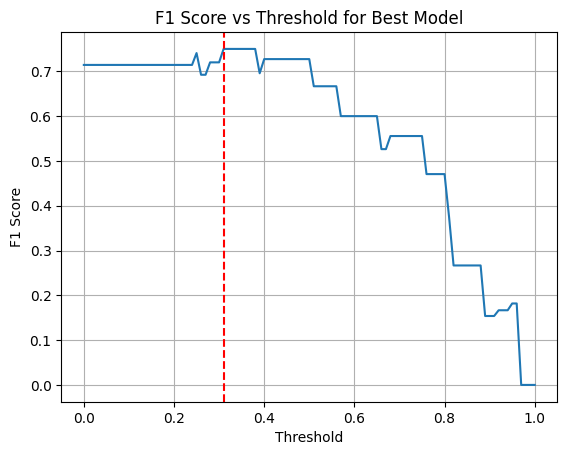

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# Example hyperparameter grid
configs = [
    {"lstm1": 100, "lstm2": 50, "dense1": 64, "dense2": 32, "drop1": 0.3, "drop2": 0.3, "drop3": 0.2, "epochs": 20, "batch_size": 32},
    {"lstm1": 128, "lstm2": 64, "dense1": 128, "dense2": 64, "drop1": 0.4, "drop2": 0.3, "drop3": 0.3, "epochs": 30, "batch_size": 64},
    # Add more configs as needed
]

best_f1 = 0
best_config = None
results = []

for idx, cfg in enumerate(configs):
    print(f"\n--- Training model {idx + 1} with config: {cfg} ---")

    inputs = Input(shape=(backcandles, len(feature_columns)))
    x = Bidirectional(LSTM(cfg['lstm1'], return_sequences=True))(inputs)
    x = Dropout(cfg['drop1'])(x)
    x = LSTM(cfg['lstm2'])(x)
    x = Dropout(cfg['drop2'])(x)
    x = Dense(cfg['dense1'], activation='relu')(x)
    x = Dropout(cfg['drop3'])(x)
    x = Dense(cfg['dense2'], activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(
        X_train_scaled, y_train,
        epochs=cfg['epochs'],
        batch_size=cfg['batch_size'],
        validation_split=0.1,
        verbose=0,
        shuffle=True
    )

    y_pred_prob = model.predict(X_test_scaled).flatten()
    thresholds = np.linspace(0, 1, 101)
    f1_scores = [f1_score(y_test, (y_pred_prob >= t).astype(int)) for t in thresholds]
    best_thresh = thresholds[np.argmax(f1_scores)]
    best_model_f1 = max(f1_scores)

    print(f"Best threshold: {best_thresh:.2f}, F1 score: {best_model_f1:.4f}")
    results.append((cfg, best_model_f1, best_thresh))

    if best_model_f1 > best_f1:
        best_f1 = best_model_f1
        best_config = cfg
        best_y_pred = (y_pred_prob >= best_thresh).astype(int)
        best_model = model

        # Save the best model
        model.save("best_model.h5")


# Final best config and evaluation
print("\n=== Best Configuration ===")
print(best_config)
print(f"Best F1 Score: {best_f1:.4f}")

print("\n--- Classification Report for Best Model ---")
print(classification_report(y_test, best_y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, best_y_pred)).plot(cmap='Blues')
plt.title("Best Model Confusion Matrix")
plt.show()

# Optional: Plot F1 score vs threshold for best model
thresholds = np.linspace(0, 1, 101)
f1_scores = [f1_score(y_test, (best_model.predict(X_test_scaled).flatten() >= t).astype(int)) for t in thresholds]
plt.plot(thresholds, f1_scores)
plt.axvline(x=results[np.argmax([r[1] for r in results])][2], color='r', linestyle='--')
plt.title("F1 Score vs Threshold for Best Model")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.grid()
plt.show()



Epoch 1/25


2/2 [==============================] - 3s 575ms/step - loss: 0.6974 - accuracy: 0.4754 - val_loss: 0.7117 - val_accuracy: 0.4286
Epoch 2/25
2/2 [==============================] - 0s 27ms/step - loss: 0.6684 - accuracy: 0.6066 - val_loss: 0.7356 - val_accuracy: 0.4286
Epoch 3/25
2/2 [==============================] - 0s 26ms/step - loss: 0.6668 - accuracy: 0.6393 - val_loss: 0.7618 - val_accuracy: 0.4286
Epoch 4/25
2/2 [==============================] - 0s 26ms/step - loss: 0.6537 - accuracy: 0.5574 - val_loss: 0.7983 - val_accuracy: 0.4286
Epoch 5/25
2/2 [==============================] - 0s 25ms/step - loss: 0.6321 - accuracy: 0.6557 - val_loss: 0.8428 - val_accuracy: 0.4286
Epoch 6/25
2/2 [==============================] - 0s 25ms/step - loss: 0.6358 - accuracy: 0.6721 - val_loss: 0.8967 - val_accuracy: 0.4286
Epoch 7/25
2/2 [==============================] - 0s 25ms/step - loss: 0.6433 - accuracy: 0.6230 - val_loss: 0.9376 - val_accuracy: 0.4286
Epoch 8/25
2/2 [=======

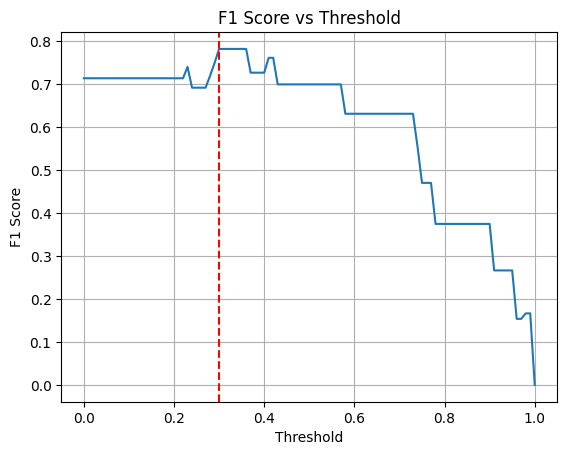

--- LSTM Classification Report ---
              precision    recall  f1-score   support

           0       0.80      0.50      0.62         8
           1       0.69      0.90      0.78        10

    accuracy                           0.72        18
   macro avg       0.75      0.70      0.70        18
weighted avg       0.74      0.72      0.71        18



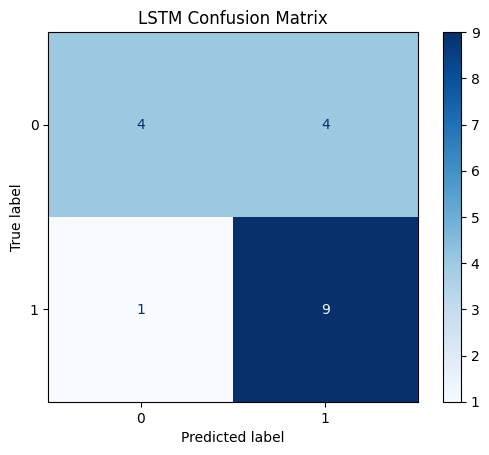

In [9]:
from tensorflow.keras.layers import Bidirectional

inputs = Input(shape=(backcandles, len(feature_columns)))
x = Bidirectional(LSTM(100, return_sequences=True))(inputs)
x = Dropout(0.3)(x)
x = LSTM(50)(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)

outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train, epochs=25, batch_size=32, validation_split=0.1, verbose=1, shuffle=True)

y_pred_prob = model.predict(X_test_scaled).flatten()
thresholds = np.linspace(0, 1, 101)
f1_scores = [f1_score(y_test, (y_pred_prob >= t).astype(int)) for t in thresholds]
best_thresh = thresholds[np.argmax(f1_scores)]
print(f"Best threshold: {best_thresh:.2f}, F1 score: {max(f1_scores):.4f}")

plt.plot(thresholds, f1_scores)
plt.axvline(best_thresh, color='r', linestyle='--')
plt.title("F1 Score vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.grid()
plt.show()

y_pred_lstm = (y_pred_prob >= best_thresh).astype(int)
print("--- LSTM Classification Report ---")
print(classification_report(y_test, y_pred_lstm))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_lstm)).plot(cmap='Blues')
plt.title("LSTM Confusion Matrix")
plt.show()
